### What is the sentiment of this film review?

In [1]:
# !pip install ecco
import ecco

lm = ecco.from_pretrained('mistralai/Mistral-7B-v0.1', gpu=False)
review="""Denis Villeneuve's Dune looks and sounds amazing -- and once the 
(admittedly slow-building) story gets you hooked, you'll be on the edge 
of your seat for the sequel."""

output = lm.generate(f"sst2 sentence: {review}", generate=1, do_sample=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
MistralModel is using MistralSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>


Use a large language model (T5 in this case) to detect text sentiment. In addition to the sentiment, see the tokens the model broke the text into (which can help debug some edge cases).

### Which words in this review lead the model to classify its sentiment as "negative"?

In [2]:
import ecco
# lm = ecco.from_pretrained('t5-small', verbose=False)
review="""I have a well-documented weakness for sci-fi and expected Dune 
to feed my soul. I didn't expect it to entirely blow my mind."""

output = lm.generate(f"sst2 sentence: {review}", generate=1, do_sample=False, attribution=['ig'])
output.primary_attributions(attr_method='ig', ignore_tokens=[0,1,2,3,4,5,6,43,44])

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<IPython.core.display.Javascript object>

IndexError: index 43 is out of bounds for axis 0 with size 42


Feature attribution using Integrated Gradients helps you explore model decisions. In this case, switching "weakness" to "inclination" allows the model to correctly switch the prediction to *positive*.

### Explore the world knowledge of GPT models by posing fill-in-the blank questions.

In [3]:
import ecco
# lm = ecco.from_pretrained('gpt2')
# lm = ecco.from_pretrained('mistralai/Mistral-7B-v0.1', gpu=False)
prompt=""" Heathrow airport is located in the city of"""

output = lm.generate(prompt, generate=1, do_sample=False)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<IPython.core.display.Javascript object>


Does GPT2 know where Heathrow Airport is? Yes. It does.

### What other cities/words did the model consider in addition to London?

In [4]:
# import ecco
# lm = ecco.from_pretrained('gpt2', verbose=False)
# lm = ecco.from_pretrained('mistralai/Mistral-7B-v0.1', gpu=False)
prompt=""" Heathrow airport is located in the city of"""

output = lm.generate(prompt, generate=1, do_sample=False, attribution=['ig'])
output.primary_attributions(attr_method='ig')

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
output.layer_predictions

<bound method OutputSeq.layer_predictions of <ecco.output.OutputSeq object at 0x7f834729c850>>

In [6]:
output._get_hidden_states()

(None,
 [tensor([[[-8.8766e-04,  2.6857e-03, -1.8600e-01,  ...,  2.3186e-06,
            -1.4455e-03, -1.9542e-03],
           [ 7.8486e-03,  1.9305e-03,  6.7913e-03,  ...,  6.1828e-03,
            -2.9345e-03, -4.3935e-04],
           [ 2.0729e-03, -4.0977e-03,  7.4051e-03,  ..., -1.9339e-03,
            -1.6127e-03, -3.7267e-03],
           ...,
           [ 3.1811e-03, -1.4793e-03,  1.2164e-03,  ...,  1.3331e-03,
             8.7309e-04, -2.3857e-03],
           [ 1.9402e-03, -3.0069e-03,  3.0755e-03,  ...,  5.7066e-03,
             2.7890e-03, -4.9941e-03],
           [ 8.9543e-04, -1.3183e-03,  4.0324e-04,  ...,  9.1785e-04,
            -1.7421e-03, -3.8387e-04]],
  
          [[-1.2002e-01, -3.9148e-01, -1.4112e-01,  ...,  7.0582e-03,
             2.0792e-02, -5.9037e-02],
           [ 1.5263e-02,  4.2630e-03,  2.3083e-02,  ...,  1.2507e-03,
             1.7685e-03, -1.4414e-02],
           [ 5.2123e-03, -9.1736e-03,  1.0984e-02,  ..., -8.6267e-04,
            -2.0873e-03, -2.801


Visuals the candidate output tokens and their probability scores.

### Which input words lead it to think of London?

In [13]:
output.layer_predictions(position=12, layer=31)

<IPython.core.display.Javascript object>

/scratch/eboros/projects/ecco/src/ecco/output.py:469: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_id = torch.tensor(self.token_ids[0][offset + j])


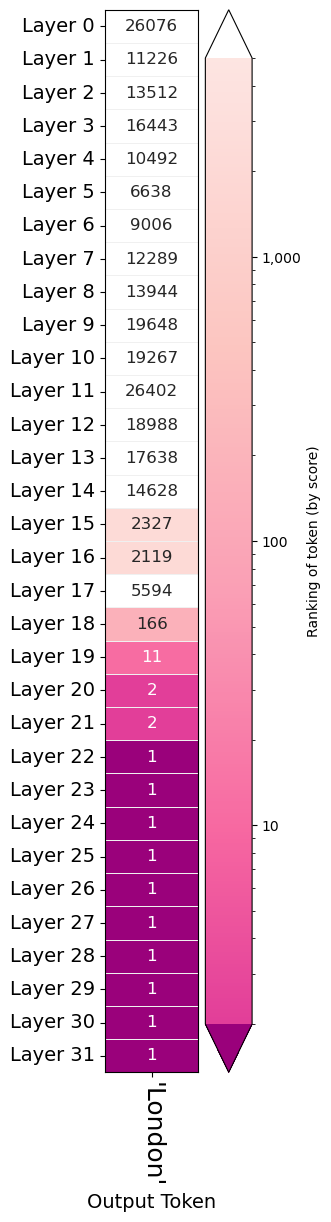

In [14]:
output.rankings()


### At which layers did the model gather confidence that London is the right answer?

c:\users\msx\pycharmprojects\ecco\src\ecco\output.py:473: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_id = torch.tensor(self.token_ids[0][offset + j])


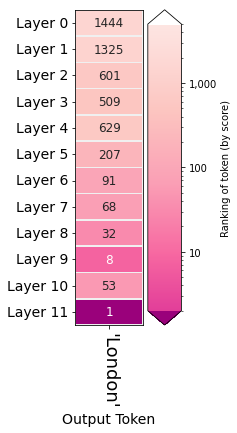

In [7]:
output.rankings()


The model chose London by making the highest probability token (ranking it #1) after the last layer in the model. How much did each layer contribute to increasing the ranking of *London*? This is a [logit lens](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens) visualizations that helps explore the activity of different model layers.

### What are the patterns in BERT neuron activation when it processes a piece of text? 

In [15]:
import ecco
# lm = ecco.from_pretrained('distilbert-base-uncased', activations=True)
text = ''' Now I ask you: \n what can be expected of man since he is a being endowed with strange qualities? Shower upon him every earthly blessing, drown him in a sea of happiness, so that nothing but bubbles of bliss can be seen on the surface; give him economic prosperity, such that he should have nothing else to do but sleep, eat cakes and busy himself with the continuation of his species, and even then out of sheer ingratitude, sheer spite, man would play you some nasty trick. He would even risk his cakes and would deliberately desire the most fatal rubbish, the most uneconomical absurdity, simply to introduce into all this positive good sense his fatal fantastic element. It is just his fantastic dreams, his vulgar folly that he will desire to retain, simply in order to prove to himself--as though that were so necessary-- that men still are men and not the keys of a piano, which the laws of nature threaten to control so completely that soon one will be able to desire nothing but by the calendar. And that is not all: even if man really were nothing but a piano-key, even if this were proved to him by natural science and mathematics, even then he would not become reasonable, but would purposely do something perverse out of simple ingratitude, simply to gain his point. And if he does not find means he will contrive destruction and chaos, will contrive sufferings of all sorts, only to gain his point! He will launch a curse upon the world, and as only man can curse (it is his privilege, the primary distinction between him and other animals), may be by his curse alone he will attain his object--that is, convince himself that he is a man and not a piano-key!
'''
inputs = lm.tokenizer([text], return_tensors="pt")
output = lm(inputs)


In [16]:
output.activations

defaultdict(dict, {})

In [17]:
nmf_1 = output.run_nmf(n_components=8) 


ValueError: need at least one array to concatenate

In [ ]:
nmf_1.explore()